In [7]:
import math
import json
import pandas as pd
import numpy as np
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [84]:
def calc_divergence(cov, gene, window):
    #Find fraction of sites that differ from root and average among all viruses at each time point
    input_file_root = '../'+str(cov)+'/auspice/seasonal_corona_'+str(cov)+'_'+str(gene)+'_root-sequence.json'
    input_file_alignment = '../'+str(cov)+'/results/aligned_'+str(cov)+'_'+str(gene)+'.fasta'
    metafile = '../'+str(cov)+'/results/metadata_'+str(cov)+'_'+str(gene)+'.tsv'

    #Subset data based on time windows
    meta = pd.read_csv(metafile, sep = '\t')
    meta.drop(meta[meta['date']=='?'].index, inplace=True)
    meta['year'] = meta['date'].str[:4].astype('int')
    date_range = meta['year'].max() - meta['year'].min()
    
    #Group viruses by time windows
    virus_time_subset = {}
    if window == 'all':
        years = str(meta['year'].min()) + '-' + str(meta['year'].max())
        virus_time_subset[years] = meta['strain'].tolist()
    else:
        date_window_start = meta['year'].min()
        date_window_end = meta['year'].min() + window
        while date_window_end <= meta['year'].max():
            years = str(date_window_start) + '-' + str(date_window_end)
            strains = meta[(meta['year']>=date_window_start) & (meta['year']<date_window_end)]['strain'].tolist()
            virus_time_subset[years] = strains
            #sliding window
            date_window_end += 1
            date_window_start += 1     

    #initiate lists to record all time windows
    year_windows = []
    seqs_in_window = []
    total_subs_fractions = []
    syn_fractions = []
    nonsyn_fractions = []
    total_subs_fractions_avg = []
    syn_fractions_avg = []
    nonsyn_fractions_avg = []
    
    for years, subset_viruses in virus_time_subset.items():
        if len(subset_viruses) != 0:
            year_windows.append(years)
            seqs_in_window.append(len(subset_viruses))
            
            root_seq = ''
            root_aa_seq = ''
            with open(input_file_root, "r") as root_handle:
                root = json.load(root_handle)
                root_seq = SeqRecord(Seq(root['nuc']))
                root_aa_seq = root_seq.translate()

            fraction_subs = []
            fraction_syn = []
            fraction_nonsyn = []

            with open(input_file_alignment, "r") as aligned_handle:
                for virus in SeqIO.parse(aligned_handle, "fasta"):
                    #Only viruses in time window
                    if virus.id in subset_viruses:
                        #check
                        if len(virus.seq) != len(root_seq):
                            print(virus)
                        elif len(virus.seq) == len(root_seq):
                            count_total_unambiguous = 0
                            count_subs = 0
                            count_syn_subs = 0
                            count_nonsyn_subs = 0
                            for pos in range(len(root_seq)):
                                root_nt = str(root_seq[pos])
                                virus_nt = str(virus.seq[pos])
                                #skip ambiguous sites
                                if virus_nt != 'N':
                                    count_total_unambiguous+=1
                                    if virus_nt != root_nt:
                                        count_subs+=1
                                        #determine syn or nonsyn
                                        codon = math.floor(pos/3)
                                        codon_pos = pos-(codon*3)
                                        if codon_pos == 0:
                                            codon_nt = virus.seq[pos:(pos+3)]
                                        elif codon_pos == 1:
                                            codon_nt = virus.seq[(pos-1):(pos+2)]
                                        elif codon_pos == 2:
                                            codon_nt = virus.seq[(pos-2):(pos+1)]
                                        codon_aa = codon_nt.translate()
                                        root_aa = root_aa_seq[codon]
                                        if codon_aa != root_aa:
                                            count_nonsyn_subs+=1
                                        elif codon_aa == root_aa:
                                            count_syn_subs+=1
                            fraction_sub_virus = count_subs/count_total_unambiguous
                            fraction_subs.append(fraction_sub_virus)
                            fraction_syn_virus = count_syn_subs/count_total_unambiguous
                            fraction_syn.append(fraction_syn_virus)
                            fraction_nonsyn_virus = count_nonsyn_subs/count_total_unambiguous
                            fraction_nonsyn.append(fraction_nonsyn_virus)
                            


            fraction_subs_window = sum(fraction_subs)/len(fraction_subs)
            fraction_syn_window = sum(fraction_syn)/len(fraction_syn)
            fraction_nonsyn_window = sum(fraction_nonsyn)/len(fraction_nonsyn)
            
            total_subs_fractions.append(fraction_subs)
            syn_fractions.append(fraction_syn)
            nonsyn_fractions.append(fraction_nonsyn)
            
            total_subs_fractions_avg.append(fraction_subs_window)
            syn_fractions_avg.append(fraction_syn_window)
            nonsyn_fractions_avg.append(fraction_nonsyn_window)
            
    return year_windows, seqs_in_window, total_subs_fractions, syn_fractions, nonsyn_fractions, total_subs_fractions_avg, syn_fractions_avg, nonsyn_fractions_avg


In [85]:
def plot_divergence(cov, genes, window):

    data_to_plot = []
    for gene in genes:
        year_windows, seqs_in_window, total_subs_fractions, syn_fractions, nonsyn_fractions, total_subs_fractions_avg, syn_fractions_avg, nonsyn_fractions_avg = calc_divergence(cov, gene, window)
        #don't use windows with fewer than 3 sequences
        for window_index in range(len(year_windows)):
            if seqs_in_window[window_index] >= 3:
                for virus_syn in syn_fractions[window_index]:
                    data_to_plot.append({'year': year_windows[window_index][0:4], 
                                         'gene': gene, 'substitution': 'syn', 
                                         'divergence': virus_syn})
                for virus_nonsyn in nonsyn_fractions[window_index]:
                    data_to_plot.append({'year': year_windows[window_index][0:4], 
                         'gene': gene, 'substitution': 'nonsyn', 
                         'divergence': virus_nonsyn})
    
    df_to_plot = pd.DataFrame(data_to_plot)

    
    fig, ax = plt.subplots(figsize=(20,10))
    ax = sns.lineplot(x='year', y='divergence', hue='gene', 
                         style = 'substitution', markers = True, markersize = 20, 
                      data = df_to_plot)
    plt.title(str(cov), fontsize=20)
    ax.tick_params(labelsize=12)
    plt.xlabel('year', fontsize=18)
    plt.ylabel('divergence', fontsize=18)
    plt.legend(prop={'size': 20})
    
    

In [87]:
def plot_total_subs(cov, genes, window):

    data_to_plot = []
    for gene in genes:
        year_windows, seqs_in_window, total_subs_fractions, syn_fractions, nonsyn_fractions, total_subs_fractions_avg, syn_fractions_avg, nonsyn_fractions_avg = calc_divergence(cov, gene, window)
        #don't use windows with fewer than 3 sequences
        for window_index in range(len(year_windows)):
            if seqs_in_window[window_index] >= 3:
                for virus_sub in total_subs_fractions[window_index]:
                    data_to_plot.append({'year': year_windows[window_index][0:4], 
                                         'gene': gene, 
                                         'divergence': virus_sub})
    
    df_to_plot = pd.DataFrame(data_to_plot)

    
    fig, ax = plt.subplots(figsize=(20,10))
    ax = sns.lineplot(x='year', y='divergence', hue='gene', markers = True, markersize = 20, data = df_to_plot)
    plt.title(str(cov), fontsize=20)
    ax.tick_params(labelsize=12)
    plt.xlabel('year', fontsize=18)
    plt.ylabel('divergence', fontsize=18)
    plt.legend(prop={'size': 20})
    
    

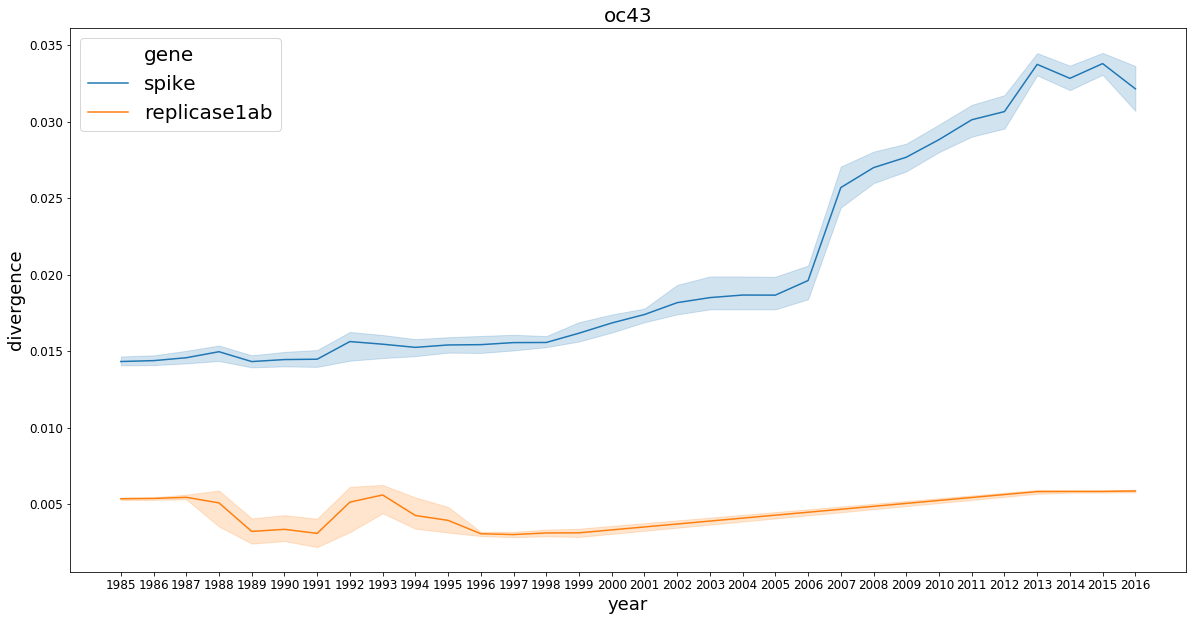

In [88]:
plot_total_subs('oc43', ['spike', 'replicase1ab'], 3)

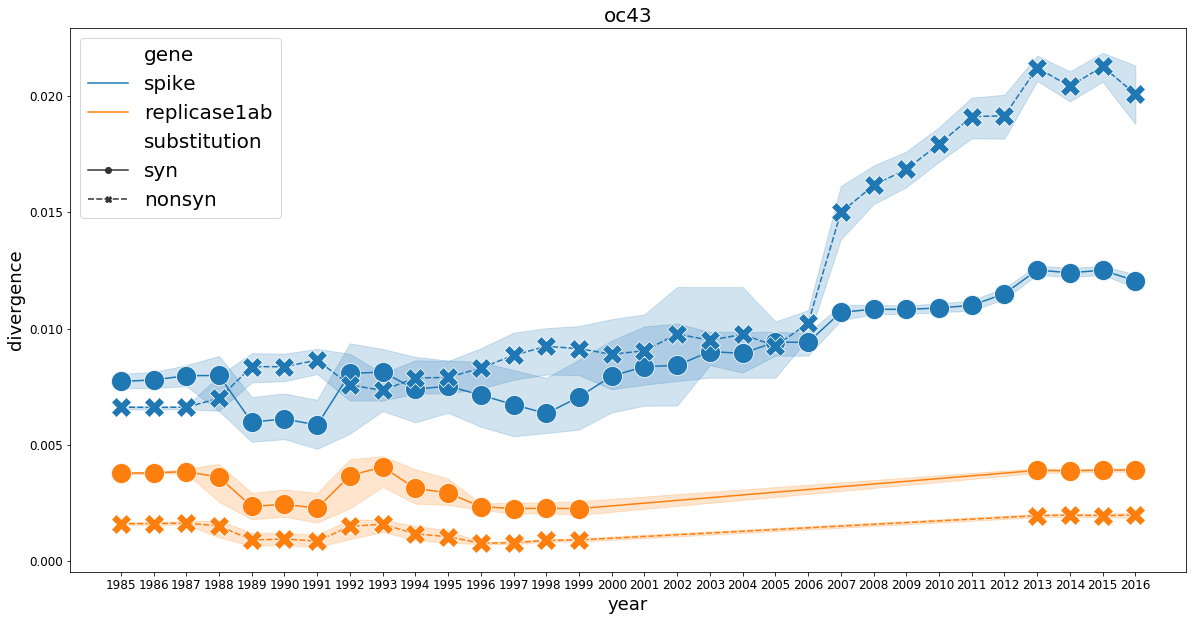

In [86]:
plot_divergence('oc43', ['spike', 'replicase1ab'], 3)

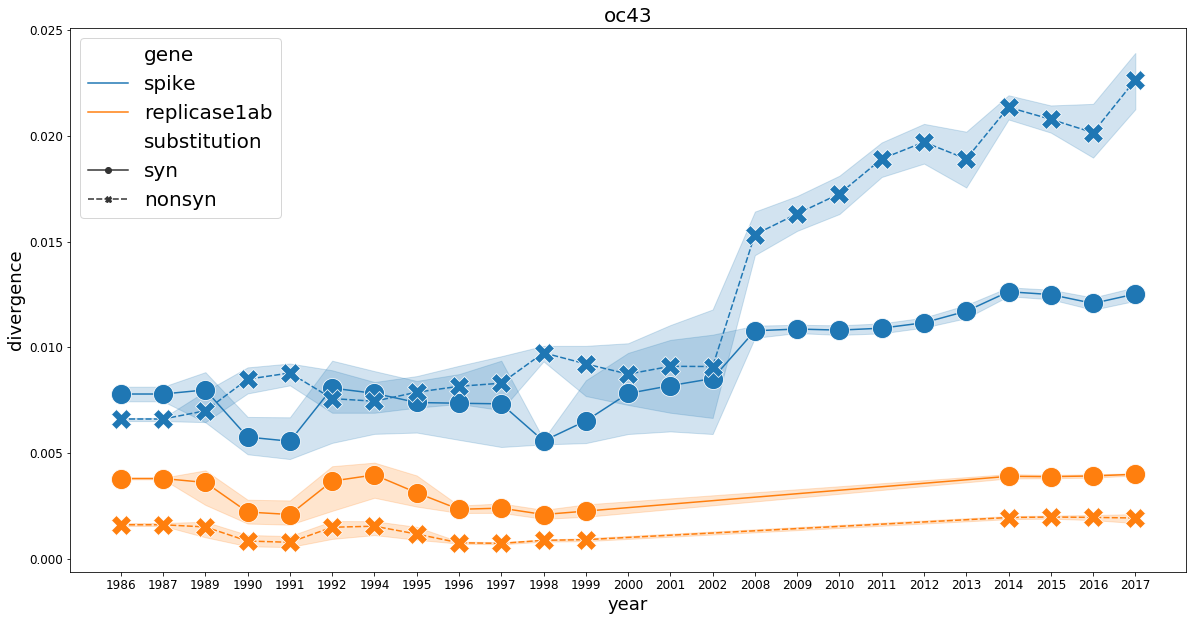

In [78]:
plot_divergence('oc43', ['spike', 'replicase1ab'], 2)

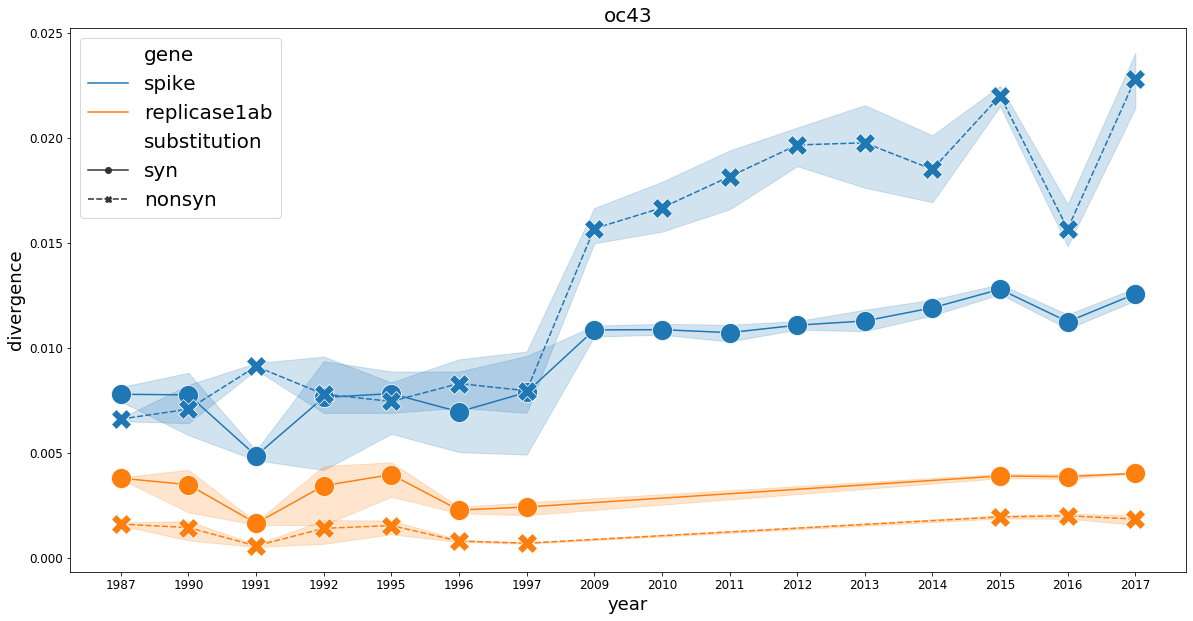

In [79]:
plot_divergence('oc43', ['spike', 'replicase1ab'], 1)

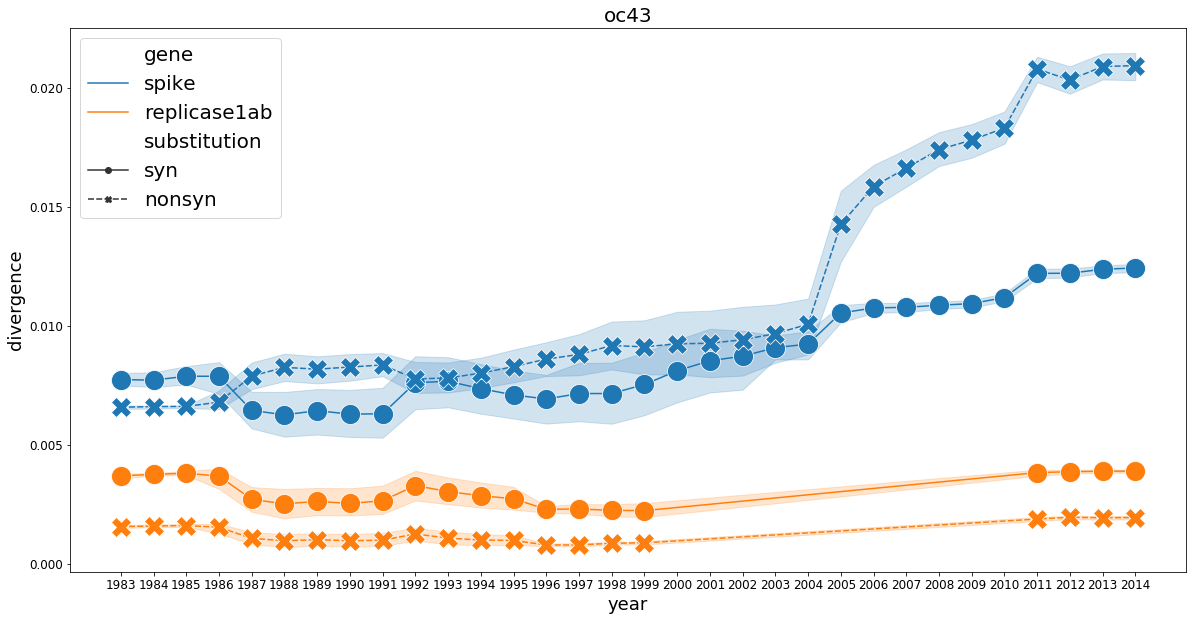

In [80]:
plot_divergence('oc43', ['spike', 'replicase1ab'], 5)

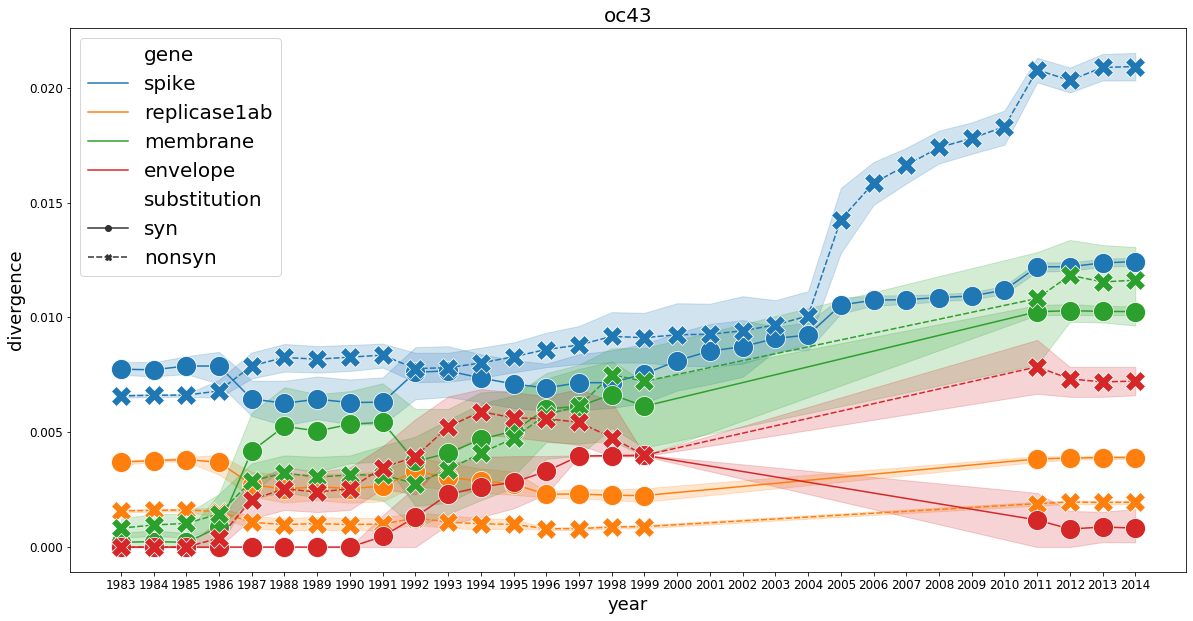

In [89]:
plot_divergence('oc43', ['spike', 'replicase1ab', 'membrane', 'envelope'], 5)

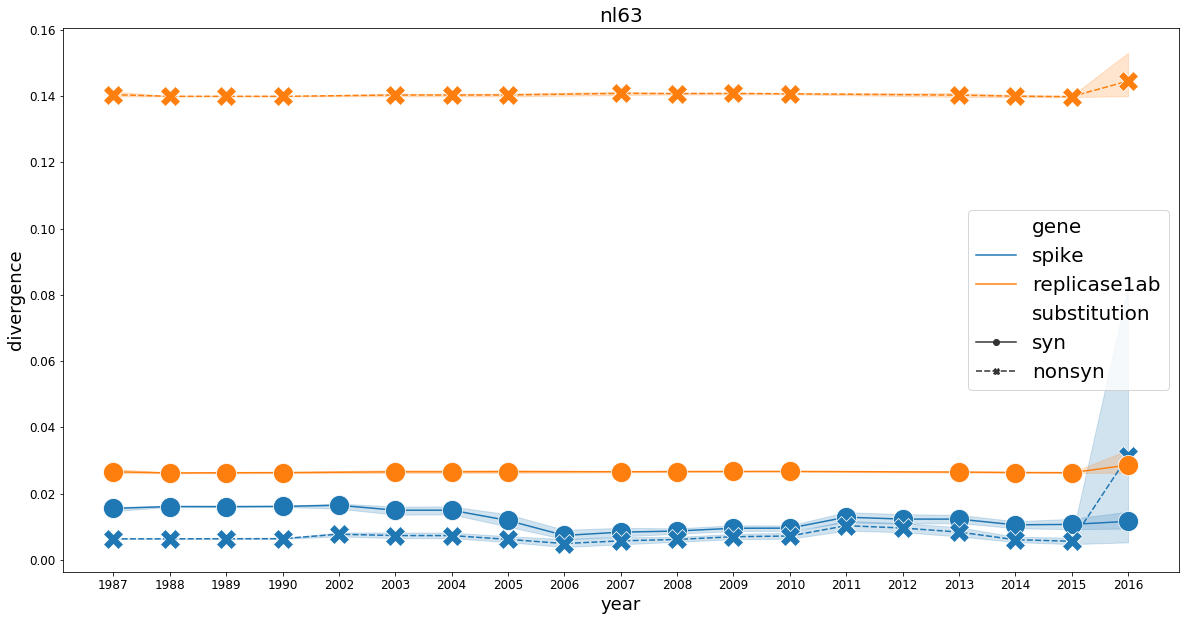

In [75]:
plot_divergence('nl63', ['spike', 'replicase1ab'], 3)

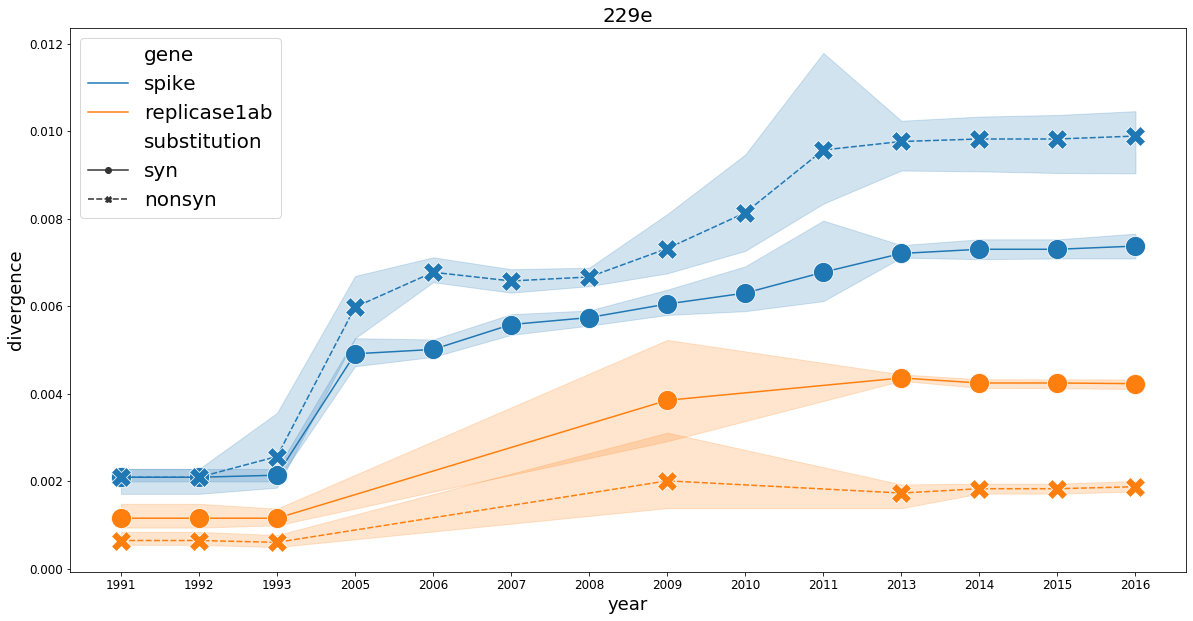

In [76]:
plot_divergence('229e', ['spike', 'replicase1ab'], 3)

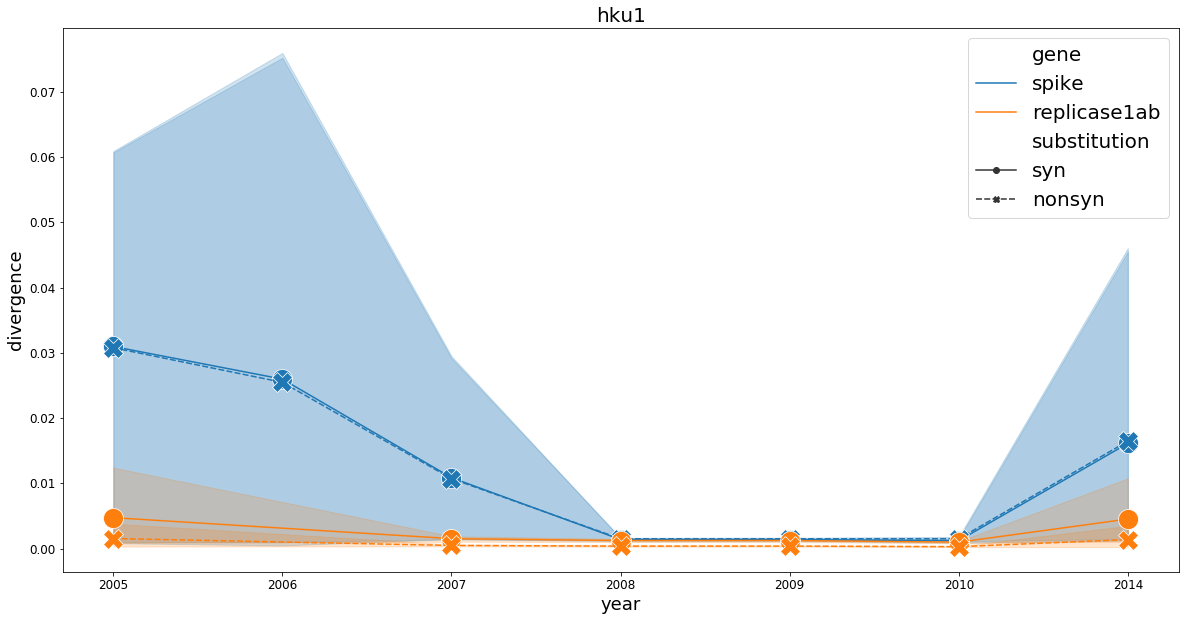

In [77]:
plot_divergence('hku1', ['spike', 'replicase1ab'], 3)

In [43]:
def plot_divergence_noci(cov, genes, window):

    data_to_plot = []
    for gene in genes:
        year_windows, seqs_in_window, syn_fractions, nonsyn_fractions, syn_fractions_avg, nonsyn_fractions_avg = calc_divergence(cov, gene, window)
        #don't use windows with fewer than 3 sequences
        for window_index in range(len(year_windows)):
            if seqs_in_window[window_index] >= 3:
                data_to_plot.append({'year': year_windows[window_index][0:4], 
                                     'gene': gene, 'syn': 'syn', 
                                     'divergence': syn_fractions_avg[window_index]})
                data_to_plot.append({'year': year_windows[window_index][0:4], 
                     'gene': gene, 'syn': 'nonsyn', 
                     'divergence': nonsyn_fractions_avg[window_index]})
    
    df_to_plot = pd.DataFrame(data_to_plot)
    
    fig, ax = plt.subplots(figsize=(20,10))
    markers = {"spike": "s", "replicase1ab": "X"}
    ax = sns.lineplot(x='year', y='divergence', hue='gene', 
                         style = 'syn', markers = True, data = df_to_plot)
    
    

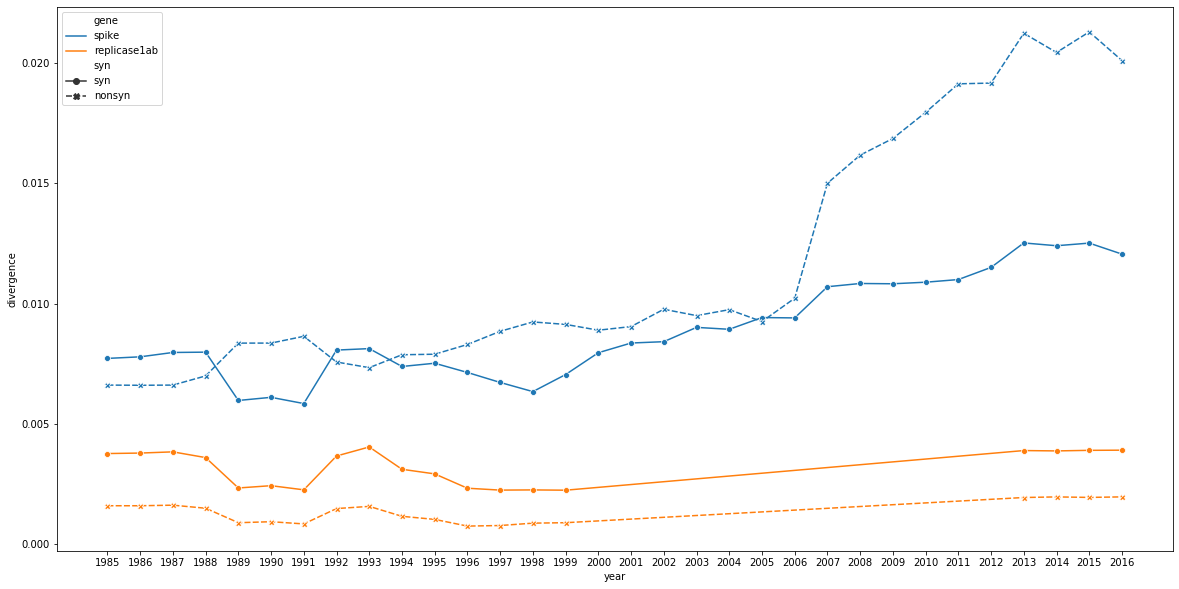

In [44]:
plot_divergence_noci('oc43', ['spike', 'replicase1ab'], 3)